# 09. Comparison of Model System Scales

## Numerical experiments - Week 04/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using PyPlot
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./plotting.jl")
Revise.includet("./setup.jl")
Revise.includet("./solver.jl")
using .Conversions
using .Diffusion
using .Plotting
using .Setup

## 1. Revision of scale assumptions - 3 options

### 1.1. Spore-scale simulation

The diffusion model developed so far is based on the discretisation of space using a single spore diameter as a spatial increment. This leads to a straightforward abstraction of the spore as a special node on the lattice which differs in its concentration contribution from the nodes of the extracellular medium. However, it could be argued that this discretisation is too arbitrary, too rough or leading to incoherences in the interpretation of the interface between spore and medium. For this reason, two additional alternative schemes are proposed.

### 1.2. Super-spore-scale simulation

First, inspired by the approach taken in the derivation of the analytical scheme in Notebook 7, it can be assumed that the spore source is of negligible size compared to the lattice resolution and that a single lattice site is a discrete box that _contains_ the spore, but their boundaries are not coincident. The spore can therefore be seen as a singular source which is not significantly large to pose an obstacle for diffusion within the box, but adds new concentration to the box with a rate based on the concentration difference between the spore and the medium. In this sense, the slow-permeating sub-system of the spore is spatially removed from the sub-system of the medium lattice, but they do communicate via the entry node assumed to contain the spore. The concentration drop between the spore and its containing cell evolves over time as follows:

$$
\begin{equation}
\frac{d{(c_{\textrm{in}}-c_{\textrm{out}})}}{dt}=-\frac{AP_s}{V}(c_{\textrm{in}}-c_{\textrm{out}})
\end{equation}
$$

This can be rewritten as

$$
\begin{equation}
\frac{d{c_{\textrm{in}}}}{dt}-\frac{d{c_{\textrm{out}}}}{dt}=-\frac{AP_s}{V}(c_{\textrm{in}}-c_{\textrm{out}}).
\end{equation}
$$

The derivative $\frac{d{c_{\textrm{out}}}}{dt}$ is approximated by a finite difference scheme:

$$
\begin{equation}
\frac{d{c_{\textrm{out}}}}{dt}\approx\frac{c_{\textrm{out}}(t+\delta{t})-c_{\textrm{out}}(t)}{\delta{t}}
\end{equation}
$$

Similarly,

$$
\begin{equation}
\frac{d{c_{\textrm{in}}}}{dt}\approx\frac{c_{\textrm{in}}(t+\delta{t})-c_{\textrm{in}}(t)}{\delta{t}}
\end{equation}
$$

Using these discretisations, the update of the spore concentration can be expressed as

$$
\begin{equation}
c_{\textrm{in}}(t+\delta{t})=c_{\textrm{out}}(t+\delta{t})+c_{\textrm{in}}(t)-c_{\textrm{out}}(t)-\frac{AP_s}{V}\delta{t}(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))=c_{\textrm{out}}(t+\delta{t})+(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))\left(1-\frac{AP_s}{V}\delta{t}\right).
\end{equation}
$$

The problem arising here is the interdependence between $c_{\textrm{in}}(t+\delta{t})$ and $c_{\textrm{out}}(t+\delta{t})$. This can be resolved by implementing a half-step for updating the concentration drop:

$$
\begin{equation}
\Delta{c}^{(1/2)}=(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))\left(1-\frac{AP_s}{2V}\delta{t}\right).
\end{equation}
$$

The outside concentration in the spore-containing volume is then updated as a mixture of free diffusion with neighbour cells of the medium and the added concentration from the source:

$$
\begin{equation}
c_{\textrm{out}}(t+\delta{t})=c_{\textrm{out}}(t)+\delta{t}\left[D\nabla^2c_{\textrm{out}}(t)+\frac{AP_s}{V}\Delta{c}^{(1/2)}\right].
\end{equation}
$$

Finally, the inside concentration at a full time step can be completed:

$$
\begin{equation}
c_{\textrm{in}}(t+\delta{t})=c_{\textrm{out}}(t+\delta{t})+\Delta{c}^{(1/2)}\left(1-\frac{AP_s}{2V}\delta{t}\right).
\end{equation}
$$

The assumptions in this scheme are more aligned with the analytical solution derived previously:

$$
\begin{equation}
c(\vec{r},t)=\frac{AP_sc_0}{(4\pi D)^{3/2}}e^{-\frac{P_sAt}{V}}4\pi\rho_s\int_0^{R_{\textrm{diff}}}{d{r}\ r^2\int_0^t{\tau'^{-3/2}\exp{\left(\frac{P_sA\tau'}{V}-\frac{r^2}{4D\tau'}\right)}d\tau'}}.\tag{2}
\end{equation}
$$

To test if the results also show alignment, the concentration at the spore, $c_{\textrm{in}}$, is determined analytically. This takes into account the fact that the concentration drop $\Delta{c}=c_{\textrm{in}}-c_{\textrm{out}}$ across the source barrier decays as

$$
\begin{equation}
\frac{d{\Delta{c}{(t)}}}{d{t}}=-\frac{AP_s}{V}{\Delta{c}{(t)}}.
\end{equation}
$$

This leads to the solution

$$
\begin{equation}
\Delta{c}{(t)}=\Delta{c}{(0)}e^{-t/\tau},
\end{equation}
$$

or, alternatively,

$$
\begin{equation}
c_{\textrm{in}}{(t)}=c_{\textrm{out}}{(t)}-\left[c_{\textrm{out}}{(0)}-c_{\textrm{in}}{(0)}\right]e^{-t/\tau},
\end{equation}
$$

$$
\begin{equation}
c_{\textrm{in}}{(t)}=c_{\textrm{out}}{(t)}+c_0e^{-t/\tau},
\tag{3}
\end{equation}
$$

<!-- In the case of multiple (periodically repeating) spores, the outside concentration is a mixture of the contributions of the measured spore and the neighbours in its vicinity:

$$
\begin{equation}
c_{\textrm{out}}{(t)}=c_{\textrm{out}}^{\textrm{(self)}}{(t)}+c_{\textrm{out}}^{\textrm{(neighbours)}}{(t)}=c_{\textrm{out}}^{\textrm{(o)}}{(t)}+\sum_{i\ne o}^M{c_{\textrm{out}}^{\textrm{(i)}}{(t)}},
\end{equation}
$$

where $o$ denotes the index of the measured source (the origin).-->

In general, the concentration released in the medium at position $\vec{r}$, consisting of all source contributions, can be computed by Equation 2. In it, the contributions from all sources are captured by the spatial integral:

$$
\begin{equation}
c_{\textrm{out}}{(t)}=\sum_i^M{c_{\textrm{out}}^{(i)}}{(\Delta{\vec{r}}_i,t)}=\frac{AP_sc_0}{(4\pi D)^{3/2}}e^{-\frac{P_sAt}{V}}4\pi\rho_s\int_0^{R_{\textrm{diff}}}{d{r}\ r^2\int_0^t{\tau'^{-3/2}\exp{\left(\frac{P_sA\tau'}{V}-\frac{r^2}{4D\tau'}\right)}d\tau'}}.
\end{equation}
$$

<!-- The release from a single source, where $r=0$, reduces to

$$
\begin{equation}
c_{\textrm{out}}^{(i)}{(\Delta{\vec{r}},t)}=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\exp{\left(-\sqrt{\frac{|\Delta{\vec{r}}|^2 P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-\sqrt{\frac{|\Delta{\vec{r}}|^2 t}{4D}}\right)}.
\end{equation}
$$

At the origin source, $\Delta{\vec{r}}$ is zero, which reduces the term to

$$
\begin{equation}
c_{\textrm{out}}^{(o)}{(\Delta{\vec{r}},t)}=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}\right)}.
\end{equation}
$$

In the limit of infinite sources, the sum over all source contributions can be approximated by an integral, accounting for the density of the sources, $\rho_s$:

$$
\begin{equation}
\sum_i^\infty{c_{\textrm{out}}^{(i)}}{(\Delta{\vec{r}},t)}\approx\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\rho_s\int_{\mathbb{R}^3}{d{\vec{r}}\left[\exp{\left(-\sqrt{\frac{|\Delta{\vec{r}}|^2 P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-\sqrt{\frac{|\Delta{\vec{r}}|^2 t}{4D}}\right)}\right]}.
\end{equation}
$$

Converting this to an integral to polar space with a radius $r=\sqrt{|\Delta{\vec{r}}|^2}$ yields

$$
\begin{equation}
\sum_i^\infty{c_{\textrm{out}}^{(i)}}{(r,t)}=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\rho_s\int_0^\infty{d{r}\ r^2\left[\exp{\left(-\sqrt{\frac{r^2 P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-\sqrt{\frac{r^2 t}{4D}}\right)}\right]\int_0^{2\pi}{d{\theta}\sin{\theta}\int_0^\pi{d{\phi}}}},
\end{equation}
$$

$$
\begin{equation}
\sum_i^\infty{c_{\textrm{out}}^{(i)}}{(r,t)}=\frac{\rho_sc_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}4\pi\int_0^\infty{d{r}\ r^2\left[\exp{\left(-r\sqrt{\frac{P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-r\sqrt{\frac{ t}{4D}}\right)}\right]},
\end{equation}
$$

$$
\begin{equation}
\sum_i^\infty{c_{\textrm{out}}^{(i)}}{(r,t)}=\frac{\rho_sc_0\sqrt{AP_sV}}{2 D^{3/2}}e^{-\frac{P_sAt}{V}}\int_0^\infty{d{r}\ r^2\left[\exp{\left(-r\sqrt{\frac{ P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-r\sqrt{\frac{ t}{4D}}\right)}\right]}.
\end{equation}
$$

To avoid over-counting the contribution of the origin source, the integral can be taken in an interval from a small distance $\epsilon$ to an upper limit relevant for diffusion ($R_{\textrm{diff}}$). Thus, the outside concentration contributed by the neighbours is

$$
\begin{equation}
c_{\textrm{out}}^{\textrm{(neighbours)}}{(r,t)}\approx\frac{\rho_sc_0\sqrt{AP_sV}}{2 D^{3/2}}e^{-\frac{P_sAt}{V}}\int_\epsilon^{R_{\textrm{diff}}}{d{r}\ r^2\left[\exp{\left(-r\sqrt{\frac{ P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-r\sqrt{\frac{ t}{4D}}\right)}\right]}.
\end{equation}
$$

The integral is difficult to solve analytically, so it is numerically evaluated. This leads to a total outside concentration at the measured site:

$$
\begin{equation}
c_{\textrm{out}}{(0,t)}=\frac{c_0\sqrt{AP_sV}}{8\pi D^{3/2}}e^{-\frac{P_sAt}{V}}\left[\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}\right)}+4\pi\rho_s\int_\epsilon^{R_{\textrm{diff}}}{d{r}\ r^2\left[\exp{\left(-r\sqrt{\frac{ P_sA}{DV}}\right)}\textrm{erfc}{\left(\sqrt{\frac{P_sA}{Vt}}-r\sqrt{\frac{ t}{4D}}\right)}\right]}\right].
\end{equation}
$$ -->

Thus, the remaining concentration in the spore is computed from Equation 3 as

$$
\begin{equation}
c_{\textrm{in}}{(0,t)} = e^{-\frac{P_sAt}{V}}\left(c_0 + \frac{\rho_sAP_sc_0}{4\pi D^{3/2}}\int_0^{R_{\textrm{diff}}}{d{r}\ r^2\int_0^t{\tau'^{-3/2}\exp{\left(\frac{P_sA\tau'}{V}-\frac{r^2}{4D\tau'}\right)}d\tau'}}\right).
\end{equation}
$$

It is important to note that the derivation of this solution relies heavily on the effective exclusion of the spore volume from the space for diffusion and therefore may lose its accuracy or produce incoherent results if the spore density is high enough to make their size compared to the intermediate spaces non-negligible.

### 1.3. Cell-wall-scale simulation

An alternative option considers a refinement of the lattice, such that the detail of the spore's spherical shape can be captured. This becomes important in observing the spatial articulation of spore packings caused by aggregation and furthermore improves the accuracy of the diffusion simulation by considering scales closer to the infinitessimal limit.

As the high resolution of the lattice requires significantly increased computation, drastic optimisation measures are required. For this purpose, each cell in the lattice performs a dynamic check of its distance to the spore centre, given the spore radius and the cell wall thickness. Two possibilities exist for distributing the diffusion regions in the spore:

1. A hollow spore core below the cell membrane, assuming that inhibitor molecules cannot enter the interior of the spore. This core is inaccessible for diffusion and is excluded from the computation.
2. A complete spore volume containing inhibitor and accessible for diffusion. This scheme lacks the heterogeneity of realistic spore structures, but aligns better with the assumptions made in the medium- and low-resolution schemes.

To be able to compare the spore-relative concentration as in the medium- and low-resolution simulations, the resulting lattice concentrations from the first option (hollow core) are related to the entirety of the spore sphere. This is performed by first multiplying each concentration by $d{x}^3$, them summing the inhibitor quantities from all cell wall nodes and dividing them by the spore volume. This calculation is perfrmed on the central spore only, disregarding the neighbour concentrations.

An important consideration is that the voxelisation of a sphere results in an overestimation of its surface area by a factor of 1.5 [1]. Hence, a correction of the permeability by 2/3 is needed in the high-resolution simulations.

## 2. Comparative experiments

The experiments use illustrative parameters. The initial concentration is normalised to $c_0=1.0\ \textrm{M}$. The permeation constant is tuned such that at $t=4\ \textrm{h}$ the concentration has decreased to 1% of its original value.

In [2]:
A, V = compute_spore_area_and_volume_from_dia(5)
Ps_fit = compute_permeation_constant(0.01, 0.0, 1.0, 14400, A, V)

0.00026650290428171825

### 2.1. Single-spore simulations

The two newly proposed options are constructed and tested against the original discretisation scheme, applying different resolutions on a lattice with the similar spatial dimensions and simulating inhibitor diffusion with a single spore. The concentration at the spore is recorded over time and compared among the numerical schemes as well as to the respective analytical solution. A lattice size of $L=N\times\delta{x}=320\mu\textrm{m}$ is used for the medium and low-resolution simulations. Due to memory limits, the high-resolution simulation is only run on a lattice of $N=256$ subdivisions, amounting to $51.2$ micrometers, but its concentration evolution is compared to an analytical counterpart with the respective spore-to-spore distance.

In [2]:
# Global parameters
D = 700 # microns^2/s
Ps_fit = 0.00026650290428171825 # microns/s
t_max = 14400 # s
c0_spore = 1.0
spore_diameter = 5 # microns
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# ----- Analytical solution -----
c_out = 0.0 # M
n_times = 1000
times = LinRange(0, t_max, n_times)

# Cube spore
V_spore_cube = spore_diameter^3 # microns^3
A_spore_cube = 6 * spore_diameter^2 # microns^2
c_analytical_cube = permeation_time_dependent_analytical(c0_spore, c_out, times, Ps_fit, A_spore_cube, V_spore_cube)
println("Analytical solution for spore with V=$V_spore_cube and A=$A_spore_cube: ", c_analytical_cube[end])

# Sphere spore
V_spore_sphere = 4π * (spore_diameter / 2)^3 / 3 # microns^3
A_spore_sphere = 4π * (spore_diameter / 2)^2 # microns^2
c_analytical_sphere = permeation_time_dependent_analytical(c0_spore, c_out, times, Ps_fit, A_spore_sphere, V_spore_sphere)
println("Analytical solution for spore with V=$V_spore_sphere and A=$A_spore_sphere: ", c_analytical_sphere[end])

# Periodic sources
# L = 320 # microns, corresponds to medium and low-resolution lattice size
# src_density = 1 / cubic_um_to_mL(L^3) # sources per micron^3
# c_analytical_ms_sparse = slow_release_pt_src_grid_at_src(src_density, c0_spore, times, D, Ps_fit, A_spore_sphere, V_spore_sphere, discrete=false)
# println("Analytical solution for periodic sources (L=$L um): ", c_analytical_ms_sparse[end])

# L = 51.2 # microns, corresponds to high-resolution lattice size
# src_density = 1 / cubic_um_to_mL(L^3) # sources per micron^3
# c_analytical_ms_dense = slow_release_pt_src_grid_at_src(src_density, c0_spore, times, D, Ps_fit, A_spore_sphere, V_spore_sphere, discrete=false)
# println("Analytical solution for periodic sources (L=$L um): ", c_analytical_ms_dense[end])

# ----- Numerical solution -----
n_save_frames = 100

# Mid resolution
N_mid = 64
dt = 0.005
spore_idx = (N_mid ÷ 2, N_mid ÷ 2, N_mid ÷ 2)
c_init = zeros(N_mid, N_mid, N_mid)
c_init[spore_idx...] = c0_spore
c_numerical_mr, times_numerical_mr, _ = diffusion_time_dependent_GPU!(c_init, t_max; D, Ps=Ps_fit, dt=dt, dx=spore_diameter, n_save_frames=n_save_frames, spore_idx=spore_idx)
println("Numerical solution (mid-resolution): ", c_numerical_mr[end, spore_idx...])

# Low resolution
scale_factor = 4 # 1 cell is 4 spore diameters long
N_lo = N_mid ÷ scale_factor
dt = 0.1
dx = spore_diameter * scale_factor
spore_vol_idx = (N_lo ÷ 2, N_lo ÷ 2, N_lo ÷ 2)
c_init = zeros(N_lo, N_lo, N_lo)
_, c_numerical_lr, times_numerical_lr, _ = diffusion_time_dependent_GPU_low_res(c_init, c0_spore, t_max; D=D, Pₛ=Ps_fit, 
                                                                                A=A_spore_sphere, V=V_spore_sphere, dt=dt, dx=dx,
                                                                                n_save_frames=n_save_frames, spore_vol_idx=spore_vol_idx)
println("Numerical solution (low-resolution): ", c_numerical_lr[end])

# High resolution (implicit, hollow)
N_hi = 256 # 1 cell is 0.20 um long
dt = 0.05
dx = 0.2 # half cell wall thickness
Db = Ps_fit * dx  / K # compute diffusion coefficient from permeability
spore_center_idx = (N_hi ÷ 2, N_hi ÷ 2, N_hi ÷ 2)
c_init = zeros(Float64, N_hi, N_hi, N_hi)
c_frames_hr_A_hc, c_numerical_hr_A_hc, times_numerical_hr_A_hc, region_ids_A_hc, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_diameter / 2, t_max;
                                                                                                                D=D^2, Db=Db, dt=dt, dx=dx,
                                                                                                                n_save_frames=n_save_frames, crank_nicolson=false)
println("Numerical solution (high-resolution, hollow core): ", c_numerical_hr_A_hc[end])

# High resolution (implicit, full)
N_hi = 256 # 1 cell is 0.20 um long
dt = 0.05
dx = 0.2 # half cell wall thickness
Db = Ps_fit * dx  / K # compute diffusion coefficient from permeability
spore_center_idx = (N_hi ÷ 2, N_hi ÷ 2, N_hi ÷ 2)
c_init = zeros(Float64, N_hi, N_hi, N_hi)
c_frames_hr_A_fc, c_numerical_hr_A_fc, times_numerical_hr_A_fc, region_ids_A_fc, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_diameter / 2, t_max;
                                                                                                                D=D^2, Db=Db, dt=dt, dx=dx,
                                                                                                                n_save_frames=n_save_frames, crank_nicolson=false, empty_interior=false)
println("Numerical solution (high-resolution, full core): ", c_numerical_hr_A_fc[end])

# # High resolution (implicit, hollow) - coarse
# N_hi = 256 # 1 cell is 0.20 um long
# dt = 0.01
# dx = 0.4 # full cell wall thickness
# Db = Ps_fit * dx  / K # compute diffusion coefficient from permeability
# spore_center_idx = (N_hi ÷ 2, N_hi ÷ 2, N_hi ÷ 2)
# c_init = zeros(Float64, N_hi, N_hi, N_hi)
# c_frames_hr_B_hc, c_numerical_hr_B_hc, times_numerical_hr_B_hc, region_ids_B_hc, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_diameter / 2, t_max;
#                                                                                                                 D=D^2, Db=Db, dt=dt, dx=dx,
#                                                                                                                 n_save_frames=n_save_frames, crank_nicolson=false, corr_factor=0.65)
# println("Numerical solution (high-resolution, coarse, hollow core): ", c_numerical_hr_B_hc[end])

# # High resolution (implicit, full) - coarse
# N_hi = 256 # 1 cell is 0.20 um long
# dt = 0.01
# dx = 0.4 # full cell wall thickness
# Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
# spore_center_idx = (N_hi ÷ 2, N_hi ÷ 2, N_hi ÷ 2)
# c_init = zeros(Float64, N_hi, N_hi, N_hi)
# c_frames_hr_B_fc, c_numerical_hr_B_fc, times_numerical_hr_B_fc, region_ids_B_fc, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_diameter / 2, t_max;
#                                                                                                                 D=D^2, Db=Db, dt=dt, dx=dx,
#                                                                                                                 n_save_frames=n_save_frames, crank_nicolson=false, corr_factor=0.65, empty_interior=false)
# println("Numerical solution (high-resolution, coarse, full core): ", c_numerical_hr_B_fc[end])

# # High resolution (explicit, full) - coarse
# N_hi = 256 # 1 cell is 0.20 um long
# dt = 0.0000025
# dx = 0.4 # full cell wall thickness
# Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
# spore_center_idx = (N_hi ÷ 2, N_hi ÷ 2, N_hi ÷ 2)
# c_init = zeros(Float64, N_hi, N_hi, N_hi)
# c_frames_hr_B_ex, c_numerical_hr_B_ex, times_numerical_hr_B_ex, region_ids_B_ex, _ = diffusion_time_dependent_GPU_hi_res!(c_init, c0_spore, [spore_center_idx], spore_diameter / 2, t_max;
#                                                                                                                 D=D^2, Db=Db, dt=dt, dx=dx,
#                                                                                                                 n_save_frames=n_save_frames, corr_factor=0.65, empty_interior=false)
# println("Numerical solution (high-resolution, coarse, full core): ", c_numerical_hr_B_ex[end])

# High resolution (implicit, full) - tiny
# N_hi = 256 # 1 cell is 0.20 um long
# dt = 0.01
# dx = 1 # full cell wall thickness
# Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
# spore_center_idx = (N_hi ÷ 2, N_hi ÷ 2, N_hi ÷ 2)
# c_init = zeros(Float64, N_hi, N_hi, N_hi)
# c_frames_hr_C_fc, c_numerical_hr_C_fc, times_numerical_hr_C_fc, region_ids_C_fc, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_spore, [spore_center_idx], spore_diameter / 2, t_max;
#                                                                                                                 D=D^2, Db=Db, dt=dt, dx=dx,
#                                                                                                                 n_save_frames=n_save_frames, crank_nicolson=false, corr_factor=0.65, empty_interior=false)
# println("Numerical solution (high-resolution, tiny, full core): ", c_numerical_hr_C_fc[end])

Analytical solution for spore with V=125 and A=150: 0.010000000000000004
Analytical solution for spore with V=65.44984694978736 and A=78.53981633974483: 0.009999999999999995
Using D = 700, Db = 0.0013325145214085911, Ps = 0.00026650290428171825
Storage arrays allocated.
Numerical solution (mid-resolution): 0.009999501518905163
Using D = 700, Ps = 0.00026650290428171825
Storage arrays allocated.
Frame 100 saved.Numerical solution (low-resolution): NaN
Spore radius in lattice units: 12.5
Using D = 490000, Db = 3.5533720570895764e-5, Dcw = 1.7766860286092088e-5
D*dt/dx2 = 612499.9999999999, Db*dt/dx2 = 4.44171507136197e-5, Dcw*dt/dx2 = 2.2208575357615106e-5
Timescale for accuracy: 8.163265306122451e-8
Storage arrays allocated.
0.9999999547361587
Frame 1 saved.0.8916682853480534
Frame 2 saved.0.7950576621133713
Frame 3 saved.0.7089265807347822
Frame 4 saved.0.632123300799114
Frame 5 saved.0.5636432832706522
Frame 6 saved.0.5025785410652286
Frame 7 saved.0.448129316424894
Frame 8 saved.0.39

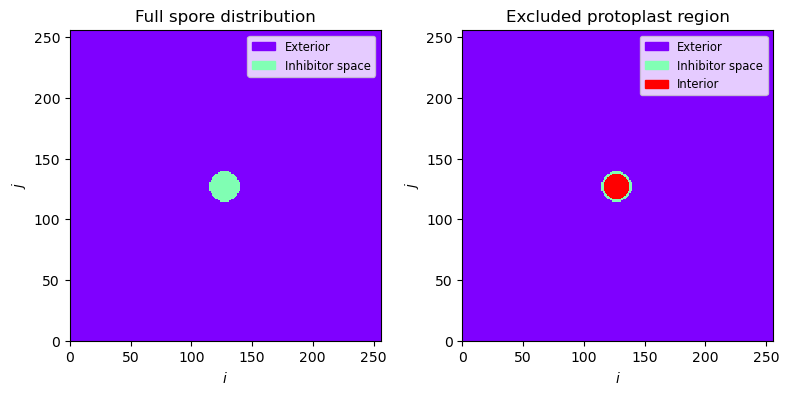

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plot_lattice_regions(region_ids_A_fc, ax=axs[1], zoom=1.0)
plot_lattice_regions(region_ids_A_hc, ax=axs[2], zoom=1.0)
axs[1].set_title("Full spore distribution")
axs[2].set_title("Excluded protoplast region")
plt.tight_layout()
gcf()

Plotting frames: [1, 2, 67, 101]


sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


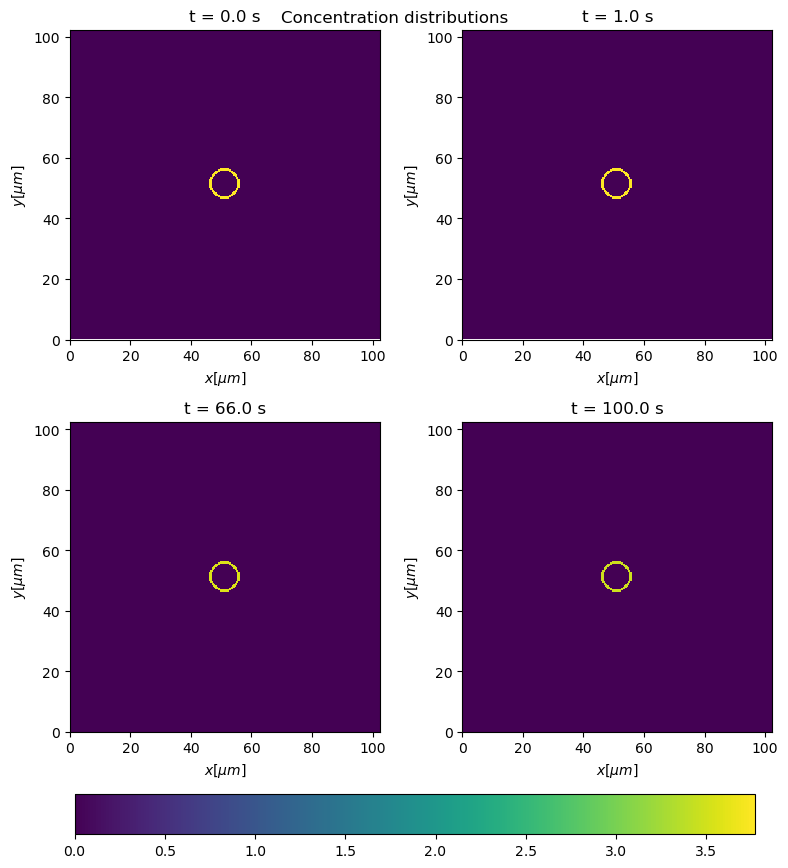

In [6]:
plot_concentration_lattice(c_frames_hr_A_hc, dx,
                            frame_indices=[1, 2, round(Int, size(c_frames_hr_A_hc)[1]*0.666), size(c_frames_hr_A_hc)[1]],
                            times=times_numerical_hr_A_hc, title="Concentration distributions")

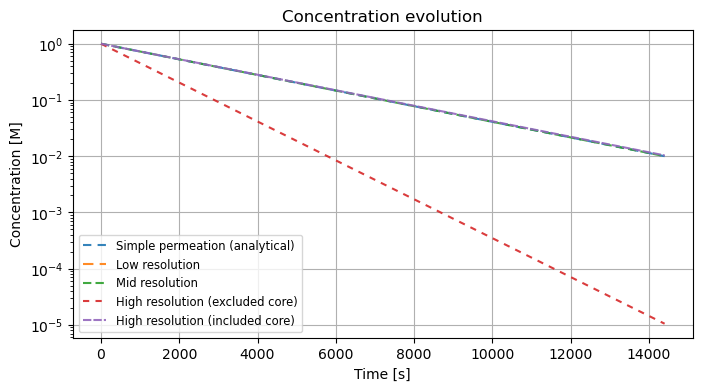

In [3]:
# compare_concentration_evolutions([c_analytical_sphere, c_numerical_lr, c_numerical_mr[:, spore_idx...],
#                                     c_numerical_hr_A_hc[:], c_numerical_hr_A_fc[:],
#                                     c_numerical_hr_B_hc[:], c_numerical_hr_B_fc[:],
#                                     c_analytical_ms_sparse, c_analytical_ms_dense],
#                                     [collect(times), times_numerical_lr, times_numerical_mr, times_numerical_hr_A_hc, times_numerical_hr_A_fc, times_numerical_hr_B_hc, times_numerical_hr_B_fc, collect(times), collect(times)],
#                                     ["Simple permeation (analytical)", "Low resolution", "Mid resolution",
#                                     "High resolution (fine, excluded core)", "High resolution (fine, included core)",
#                                     "High resolution (coarse, excluded core)", "High resolution (coarse, included core)",
#                                     "Periodic sources (sparse, analytical)", "Periodic sources (dense, analytical)"], logy=false, fit_exp=false)
# compare_concentration_evolutions([c_analytical_sphere, c_numerical_lr, c_numerical_mr[:, spore_idx...],
#                                     c_numerical_hr_A_hc[:], c_numerical_hr_A_fc[:],
#                                     c_numerical_hr_B_hc[:], c_numerical_hr_B_fc[:]],
#                                     [collect(times), times_numerical_lr, times_numerical_mr, times_numerical_hr_A_hc, times_numerical_hr_A_fc, times_numerical_hr_B_hc, times_numerical_hr_B_fc, collect(times), collect(times)],
#                                     ["Simple permeation (analytical)", "Low resolution", "Mid resolution",
#                                     "High resolution (fine, excluded core)", "High resolution (fine, included core)",
#                                     "High resolution (coarse, excluded core)", "High resolution (coarse, included core)"], logy=false, fit_exp=false)
compare_concentration_evolutions([c_analytical_sphere, c_numerical_lr, c_numerical_mr[:, spore_idx...],
                                    c_numerical_hr_A_hc[:], c_numerical_hr_A_fc[:]],
                                    [collect(times), times_numerical_lr, times_numerical_mr, times_numerical_hr_A_hc, times_numerical_hr_A_fc],
                                    ["Simple permeation (analytical)", "Low resolution", "Mid resolution",
                                    "High resolution (excluded core)", "High resolution (included core)"], logy=true)

All concentration evolutions, apart from the two high-resolution simulations with an excluded core, show a good alignment. The deviation of the latter can be explained by the fact that the pressure for permeation is increased due to the more compact compression of the inhibitor in the smaller cell wall volume.

### 2.2. Multi-spore simulations

#### 2.2.1. Time-based saturation: comparison between models

To compare the saturation effects in all available models, a series of experiments captures the concentration evolutions at gradually increasing lattice sizes in the low, medium and high-resolution setups for $t_{\textrm{max}}=4$ hours and compares them to two analytical solution accounting for an equivalent spore density: one explicitly incorporating a spatio-temporal integral for the accumulation of external concentration and another one based on volume ratio calculations under the assumption of a fast-diffusing medium.

In [ ]:
# Global parameters
D = 700 # microns^2/s
Ps_fit = 0.00026650290428171825 # microns/s
t_max = 14400 # s
c0_spore = 1.0
spore_diameter = 5 # microns
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

n_save_frames = 100

# ----- Analytical solution (explicit and simplified) -----
V_spore_sphere = 4π * (spore_diameter / 2)^3 / 3 # microns^3
A_spore_sphere = 4π * (spore_diameter / 2)^2 # microns^2
times_analytical = LinRange(0, t_max, n_save_frames+1)
# Ls_analytical = LinRange(24, 52, 15)
Ls_analytical = LinRange(25, 50, 25)
# c_analytical_Ls_ex_A = zeros(length(Ls_analytical), n_save_frames+1)
# c_analytical_Ls_ex_B = zeros(length(Ls_analytical), n_save_frames+1)
c_analytical_Ls_simp = zeros(length(Ls_analytical), n_save_frames+1)
for (i, L) in enumerate(Ls_analytical)
    src_density = 1 / cubic_um_to_mL(L^3) # sources per micron^3
    # src_density = (1 / L^3)
    # c_analytical_Ls_ex_A[i, :] = slow_release_pt_src_grid_at_src(src_density, c0_spore, times_analytical, D, Ps_fit, A_spore_sphere, V_spore_sphere, discrete=false)
    # c_analytical_Ls_ex_B[i, :] = slow_release_shell_src_at_src(src_density, c0_spore, times_analytical, D, Ps_fit, spore_diameter; discrete=false)
    c_analytical_Ls_simp[i, :] = concentration_at_spore_ambient_sources(times_analytical, c0_spore, 0.0, src_density, 0.5 * spore_diameter, Ps_fit)
    
end

# ----- Numerical solutions -----

# Low resolution
# dx = 20
# dt = 0.1
# Ns = [2, 3]
# Ls_numerical_lo = Ns .* dx
# c_numerical_lo_Ls = zeros(length(Ns), n_save_frames+1)
# for (i, N) in enumerate(Ns)
#     println("Low resolution: ", N)
#     spore_vol_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
#     c_init = zeros(N, N, N)
#     _, c_numerical_lo, times_numerical_lo, _ = diffusion_time_dependent_GPU_low_res(c_init, c0_spore, t_max; D=D, Pₛ=Ps_fit, 
#                                                                                     A=A_spore_sphere, V=V_spore_sphere, dt=dt, dx=dx,
#                                                                                     n_save_frames=n_save_frames, spore_vol_idx=spore_vol_idx)
#     c_numerical_lo_Ls[i, :] .= c_numerical_lo
# end

# Mid resolution
dx = spore_diameter
dt = 0.005
# Ns = round.(Int, (LinRange(5, 11, 7)))
Ns = round.(Int, (LinRange(5, 10, 6)))
Ls_numerical_mr = Ns .* dx
c_numerical_mr_Ls = zeros(length(Ns), n_save_frames+1)
for (i, N) in enumerate(Ns)
    println("Mid resolution: ", N)
    spore_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
    c_init = zeros(N, N, N)
    c_init[spore_idx...] = c0_spore
    println(sum(c_init))
    c_numerical_mr, times_numerical_mr, _ = diffusion_time_dependent_GPU!(c_init, t_max; D, Ps=Ps_fit, dt=dt, dx=spore_diameter, n_save_frames=n_save_frames, spore_idx=spore_idx)
    println(sum(c_numerical_mr[end, :, :, :]))
    println(size(c_numerical_mr))
    c_numerical_mr_Ls[i, :] .= c_numerical_mr[:, spore_idx...]
end

# High resolution (implicit, coarse)
dx = 0.4
dt = 0.05
Db = Ps_fit * dx  / K # compute diffusion coefficient from permeability
# Ns = Int.(LinRange(64, 128, 9))
Ns = round.(Int, LinRange(63, 125, 11))
Ls_numerical_hr = Ns .* dx
c_numerical_hr_Ls = zeros(length(Ns), n_save_frames+1)
for (i, N) in enumerate(Ns)
    println("High resolution: ", N)
    spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
    c_init = zeros(Float64, N, N, N)
    _, c_numerical_hr, times_numerical_hr, _, _ = diffusion_time_dependent_GPU_hi_res_implicit(copy(c_init), c0_spore, [spore_center_idx], spore_diameter / 2, t_max;
                                                                                                D=D^2, Db=Db, dt=dt, dx=dx,
                                                                                                n_save_frames=n_save_frames, crank_nicolson=false,
                                                                                                corr_factor=0.65, empty_interior=false)
    c_numerical_hr_Ls[i, :] .= c_numerical_hr
end

times_numerical = collect(LinRange(0, t_max, n_save_frames+1));

Mid resolution: 5
1.0
Using D = 700, Db = 0.0013325145214085911, Ps = 0.00026650290428171825
Storage arrays allocated.
0.9883181415498257
(101, 5, 5, 5)
Mid resolution: 6
1.0
Using D = 700, Db = 0.0013325145214085911, Ps = 0.00026650290428171825
Storage arrays allocated.
1.0041510546579957
(101, 6, 6, 6)
Mid resolution: 7
1.0
Using D = 700, Db = 0.0013325145214085911, Ps = 0.00026650290428171825
Storage arrays allocated.
1.000707009807229
(101, 7, 7, 7)
Mid resolution: 8
1.0
Using D = 700, Db = 0.0013325145214085911, Ps = 0.00026650290428171825
Storage arrays allocated.
1.0033721156651154
(101, 8, 8, 8)
Mid resolution: 9
1.0
Using D = 700, Db = 0.0013325145214085911, Ps = 0.00026650290428171825
Storage arrays allocated.
0.9994485364295542
(101, 9, 9, 9)
Mid resolution: 10
1.0
Using D = 700, Db = 0.0013325145214085911, Ps = 0.00026650290428171825
Storage arrays allocated.
0.9972025725292042
(101, 10, 10, 10)
High resolution: 63
Spore radius in lattice units: 6.25
Using D = 490000, Db = 

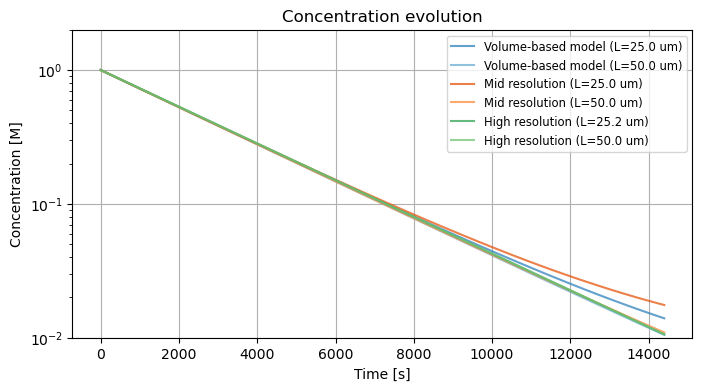

In [63]:
idx_A_an = 1
idx_B_an = 25
idx_A_mr = 1
idx_B_mr = 6
idx_A_hr = 1
idx_B_hr = 11

concentrations_groups = [[vec(c_analytical_Ls_simp[idx_A_an, :]), vec(c_analytical_Ls_simp[idx_B_an, :])],
                        [vec(c_numerical_mr_Ls[idx_A_mr, :]), vec(c_numerical_mr_Ls[idx_B_mr, :])],
                        [vec(c_numerical_hr_Ls[idx_A_hr, :]), vec(c_numerical_hr_Ls[idx_B_hr, :])]]
                        
times_groups = [[collect(times_analytical), collect(times_analytical)],
                [times_numerical, times_numerical],
                [times_numerical, times_numerical]]
                
labels = [["Volume-based model (L=$(round(Ls_analytical[idx_A_an], digits=3)) um)", "Volume-based model (L=$(round(Ls_analytical[idx_B_an], digits=2)) um)"],
        ["Mid resolution (L=$(round(Ls_numerical_mr[idx_A_mr], digits=3)) um)", "Mid resolution (L=$(round(Ls_numerical_mr[idx_B_mr], digits=2)) um)"],
        ["High resolution (L=$(round(Ls_numerical_hr[idx_A_hr], digits=3)) um)", "High resolution (L=$(round(Ls_numerical_hr[idx_B_hr], digits=2)) um)"]]
        

compare_concentration_evolution_groups(concentrations_groups, times_groups, labels, logy=true, ylim=(1e-2, 2.0))

The coarsest simulation overestimates the concentrations, understandably due to the extreme level of discretisation at 2 lattice subdivisions in each dimension. When increased to 3 subdivisions, the low-resolution scheme still produces saturation results higher than all the other schemes.

An indication for saturation is visible already at $L=40$ micrometers in the medium-resolution scheme and is amplified at $L=20$ micrometers, albeit not as much as the results from the low-resolution simulations. It appears that the simplified analytical solution comes closest to the results yielded by the medium-resolution numerical solver.

Despite operating on a comparable range of lattice sizes, the high-resolution simulations do not seem to diverge significantly between different $L$ values. Both extremes evolve along a similar trajectory, slightly overestimating the analytical solutions, possibly due to discretisation artifacts.

The two more elaborate analytical solutions exhibit no visible difference at any of the measured lattice sizes.

#### 2.2.2. Saturation at $t=4$ h

A closer look into the final concentrations at $t=4$ hours may reveal clearer characteristic relationships between spore density and inhibitor saturation. To normalise the results for a better preview, the low-resolution solutions are discarded as coarsest and least meaningful, and the relative differences from the lowest concentration reached at a certain spore-to-spore distance are shown.

3600.0
3600.0
Analytical
Numerical (mid-res)
Numerical (high-res)


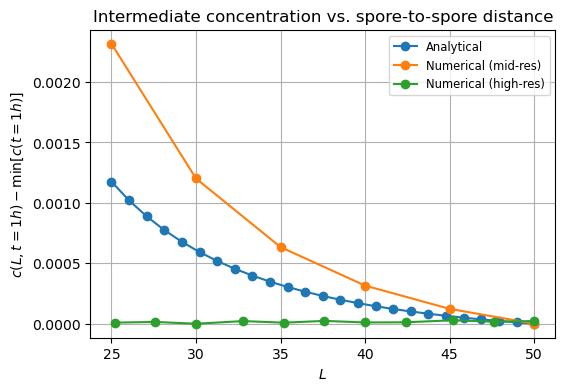

In [64]:
time_idx = 26
c_analytical_final = c_analytical_Ls_simp[:, time_idx]
c_numerical_mr_final = c_numerical_mr_Ls[:, time_idx]
c_numerical_hr_final = c_numerical_hr_Ls[:, time_idx]
println(times_analytical[time_idx])
println(times_numerical[time_idx])
# compare_functional_relationships([Ls_analytical, Ls_numerical_lo, Ls_numerical_mr, Ls_numerical_hr],
#                                 [c_analytical_final.-minimum(c_analytical_final), c_numerical_lo_final.-minimum(c_numerical_lo_final), c_numerical_mr_final.-minimum(c_numerical_mr_final), c_numerical_hr_final.-minimum(c_numerical_hr_final)],
#                                 [L"L", L"c(t=3600)"], ["Analytical", "Numerical (low-res)", "Numerical (mid-res)", "Numerical (high-res)"],
#                                 "Final concentration vs. density"; logy=false, fit=nothing)

compare_functional_relationships([Ls_analytical, Ls_numerical_mr, Ls_numerical_hr],
                                [c_analytical_final.-minimum(c_analytical_final), c_numerical_mr_final.-minimum(c_numerical_mr_final), c_numerical_hr_final.-minimum(c_numerical_hr_final)],
                                [L"L", L"c(L, t=1h)-\min[c(t=1h)]"], ["Analytical", "Numerical (mid-res)", "Numerical (high-res)"],
                                "Intermediate concentration vs. spore-to-spore distance"; logy=false, fit=nothing)

14400.0
14400.0
Analytical
Numerical (mid-res)
Numerical (high-res)


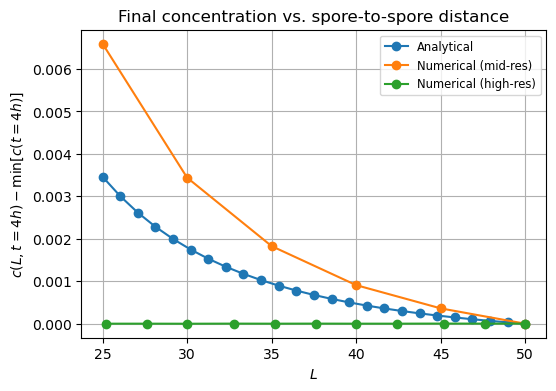

In [66]:
time_idx = 101
c_analytical_final = c_analytical_Ls_simp[:, time_idx]
c_numerical_mr_final = c_numerical_mr_Ls[:, time_idx]
c_numerical_hr_final = c_numerical_hr_Ls[:, time_idx]
println(times_analytical[time_idx])
println(times_numerical[time_idx])

compare_functional_relationships([Ls_analytical, Ls_numerical_mr, Ls_numerical_hr],
                                [c_analytical_final.-minimum(c_analytical_final), c_numerical_mr_final.-minimum(c_numerical_mr_final), c_numerical_hr_final.-minimum(c_numerical_hr_final)],
                                [L"L", L"c(L, t=4h)-\min[c(t=4h)]"], ["Analytical", "Numerical (mid-res)", "Numerical (high-res)"],
                                "Final concentration vs. spore-to-spore distance"; logy=false, fit=nothing)

3600.0
3600.0
Analytical
Numerical (mid-res)


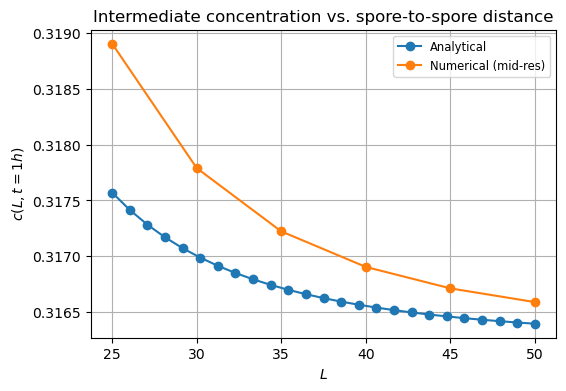

In [67]:
time_idx = 26
c_analytical_final = c_analytical_Ls_simp[:, time_idx]
c_numerical_mr_final = c_numerical_mr_Ls[:, time_idx]
c_numerical_hr_final = c_numerical_hr_Ls[:, time_idx]
println(times_analytical[time_idx])
println(times_numerical[time_idx])

compare_functional_relationships([Ls_analytical, Ls_numerical_mr],
                                [c_analytical_final, c_numerical_mr_final],
                                [L"L", L"c(L, t=1h)"], ["Analytical", "Numerical (mid-res)"],
                                "Intermediate concentration vs. spore-to-spore distance"; logy=false, fit=nothing)

14400.0
14400.0
Analytical
Numerical (mid-res)


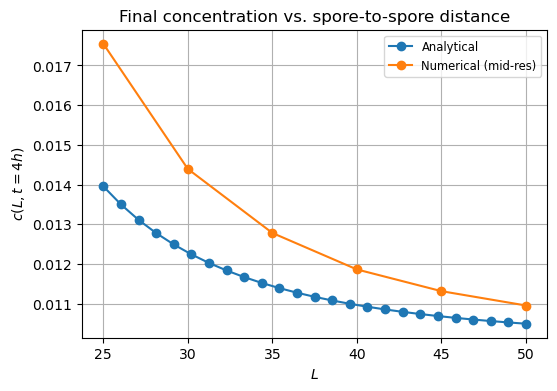

In [69]:
time_idx = 101
c_analytical_final = c_analytical_Ls_simp[:, time_idx]
c_numerical_mr_final = c_numerical_mr_Ls[:, time_idx]
c_numerical_hr_final = c_numerical_hr_Ls[:, time_idx]
println(times_analytical[time_idx])
println(times_numerical[time_idx])

compare_functional_relationships([Ls_analytical, Ls_numerical_mr],
                                [c_analytical_final, c_numerical_mr_final],
                                [L"L", L"c(L, t=4h)"], ["Analytical", "Numerical (mid-res)"],
                                "Final concentration vs. spore-to-spore distance"; logy=false, fit=nothing)

The trends exhibited by $c(L)$ at $t=1$ hour and $t=4$ hours show a significant amount of noise in the solution from the high-resolution model, possibly due to numerical error in the implicit scheme. The medium-resolution model and the analytical solution, however, exhibit an exponential-like behaviour in the decrease of measured concentrations with increasing $L$. At the 1-hour mark, the concentrations computed by the two models are closly aligned. By the end of the 4-hour course, the solutions slightly diverge but the relationship between inter-spore distance and spore concentration remains qualitatively similar - a trend steeper than exponential or power-law.

This indicates that the manner in which saturation is approached in the two models is similar, yet numerical error may distort the results in the lattice-based simulation at long times.

## 3. Additional studies

### 3.1. Sparse matrix exercise

In [ ]:
using SparseArrays
using IterTools

In [ ]:
N = 20
rad = 5
spore_idx = (N ÷ 2, N ÷ 2)
medium_is, medium_js, medium_cs = [], [], []
cw_is, cw_js, cw_concs = [], [], []
for i in 1:N
    for j in 1:N
        steps = [-1, 0, 1]
        von_neumann_nbrs = collect(IterTools.product(steps, steps))
        excluded = false
        excluded_nbrs = 0
        for (di, dj) in von_neumann_nbrs
            if (i + di - spore_idx[1])^2 + (j + dj - spore_idx[2])^2 > rad^2
                if (di, dj) == (0, 0)
                    excluded = true
                    push!(medium_is, i)
                    push!(medium_js, j)
                    push!(medium_cs, 1.0)
                else
                    excluded_nbrs += 1
                end
            end
        end
        if !excluded && excluded_nbrs > 0
            push!(cw_is, i)
            push!(cw_js, j)
            push!(cw_concs, 1.0)
        end
    end
end
# nz_is = hcat(nz_is...)
# nx_js = hcat(nx_js...)
# nz_concs = hcat(nz_concs...)
medium_sparse = sparse(medium_is, medium_js, medium_cs, N, N)
cw_sparse = sparse(cw_is, cw_js, cw_concs, N, N)

20×20 SparseMatrixCSC{Any, Int64} with 36 stored entries:
⎡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⢠⠖⠚⠒⢦⠀⠀⠀⎥
⎢⠀⠀⢺⠀⠀⠀⢸⠂⠀⠀⎥
⎢⠀⠀⠈⠓⠲⠒⠋⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

### 3.2. Oscillation in the Crank-Nicholson scheme

The plot below shows the measured oscillations in the solutions from the Crank-Nelson implicit method at low time steps.

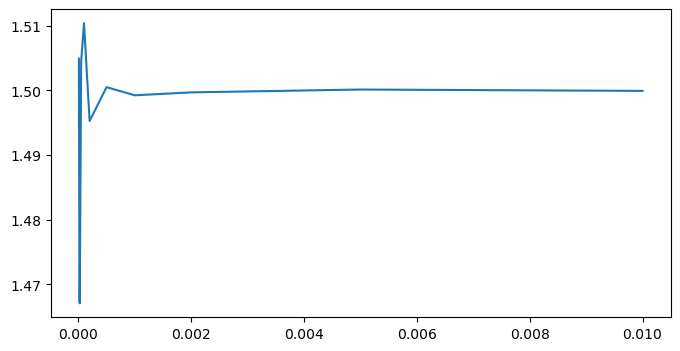

In [3]:
fig, ax = subplots(1, 1, figsize=(8, 4))
ax.plot([0.00001, 0.00002, 0.000025, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01],
    [1.5048929224400762, 1.4675215172683493, 1.467079706082919, 1.504441259753694, 1.5103601182596633, 1.4952611300259646, 1.5004846588950445, 1.4992288034937455, 1.4996793205407004, 1.5001188115480535, 1.499909844061341])
gcf()

## References

- [1] Rajon, D., Patton, P.W., Shah, A.P., Watchman, C.J., & Bolch, W.E. (2002). Surface area overestimation within three-dimensional digital images and its consequence for skeletal dosimetry. Medical physics, 29 5, 682-93 .